In [1]:
import matplotlib
import sys
sys.path.append('..')
from scipy import signal, stats, io
from tmfc_simulation.wilson_cowan_task_simulation import WCTaskSim, HRF
from tmfc_simulation.synaptic_weights_matrices import normalize, generate_synaptic_weights_matrices
from tmfc_simulation.read_utils import read_onsets_from_mat, generate_sw_matrices_from_mat
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
np.set_printoptions(suppress=True)
%load_ext autoreload
%autoreload 2

# Simulation of fmri data with changing synaptic weigths

The package allows users to generate fMRI time series, based on modification on Wilson-Cowan model implemented in neurolib library (Cakan, C., Jajcay, N. & Obermayer, K. neurolib: A Simulation Framework for Whole-Brain Neural Mass Modeling. Cogn. Comput. (2021). https://doi.org/10.1007/s12559-021-09931-9). The main differences from neurolib realization: 
  - possibility to change synaptic weight matrix with the time
  - possibility to use synaptic activity as output instead of excitation or inhibition (as described in Horwitz and Tagamets (1999))
  - possibility to save neural signal with lower resolution
  - possibility to change TR in bold signal convolution
  - possibility to change HRF type for convolution

Example with three different synaptic weight matrices for rest,  task A and B demonstrated below

### Matrix generation

In [2]:
num_regions = 30
num_modules = 3
X = 0.9
Z = 0.5
rest_factors = np.array([[X, 0.1, 0.1],
                                 [0.1, X, 0.1],
                                 [0.1, 0.1, X]])
taskA_factors = np.array([[X, Z, 0.1],
                                  [Z, X, 0.1],
                                  [0.1, 0.1, X]])
taskB_factors = np.array([[X, 0.1, Z],
                                  [0.1, X, 0.1],
                                  [Z, 0.1, X]])

c_rest = generate_synaptic_weights_matrices(num_regions,
                                            num_modules,
                                            factors=rest_factors,
                                            sigma=0.1)
c_task_a = generate_synaptic_weights_matrices(num_regions,
                                              num_modules,
                                              factors=taskA_factors,
                                              sigma=0.1)
c_task_b = generate_synaptic_weights_matrices(num_regions,
                                                      num_modules,
                                                      factors=taskB_factors,
                                                      sigma=0.1)
D = np.ones((num_regions, num_regions)) * 250
np.fill_diagonal(D, 0)
norm_type = "cols"
Wij_rest = normalize(c_rest, norm_type=norm_type)
c_task_a = normalize(c_task_a, norm_type=norm_type)
c_task_b = normalize(c_task_b, norm_type=norm_type)
Wij_task_dict = {"task_A": c_task_a, "task_B": c_task_b}

In [17]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)
#plotting function
def plot_bold_corr(wc_block, 
                   BOLD=None,
                   TR=2, 
                   drop_first_rest=8,
                   drop_start_block=6):
    num_tasks = len(wc_block.time_idxs_dict.keys())
    mean_bold_matrices = {}

    if BOLD is None:
        BOLD = wc_block.BOLD
        
    start_idx = abs(wc_block.time_idxs_dict["Rest"][0][0])

    for task_name in wc_block.time_idxs_dict.keys():
        bold_series = []
        for i in range(len(wc_block.time_idxs_dict[task_name])):
            idxs = wc_block.time_idxs_dict[task_name][i]
            idxs = [int((idx+start_idx)//TR) for idx in idxs]
            if i==0:
                bold_series.append(BOLD[:,idxs[0]+int(drop_first_rest/TR):idxs[1]])
            else:
                bold_series.append(BOLD[:,idxs[0]+int(drop_start_block/TR):idxs[1]])
        concat_bold = np.concatenate(bold_series, axis=1)
        mean_bold_matrices["FC_"+task_name] = np.corrcoef(concat_bold)
        
    fig, axs = plt.subplots(2, num_tasks, figsize = (12,8))
    C_list = list(mean_bold_matrices.values())

    for i, (title, C) in enumerate(mean_bold_matrices.items()):
        axs[0, i].imshow(C); axs[0,i].set_title(title);
        axs[1, i].imshow(C - mean_bold_matrices["FC_Rest"]); axs[1,i].set_title(title+"-Rest");
    fig.suptitle("Mean block FC matrices");    
    return mean_bold_matrices

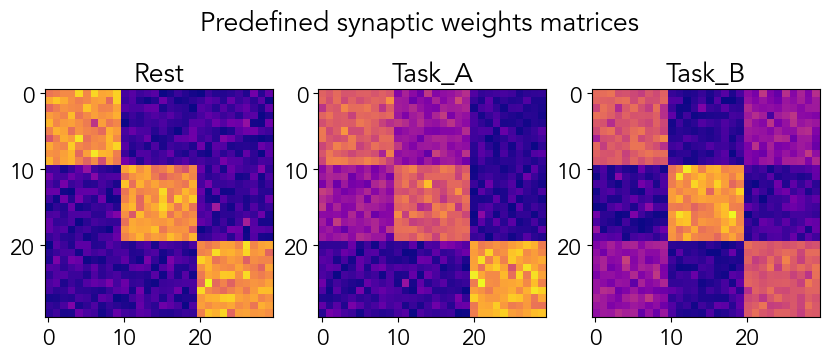

In [4]:
titles = ["Rest", "Task_A", "Task_B"]
syn_mats = [Wij_rest, c_task_a, c_task_b]
fig, axs = plt.subplots(1, 3, figsize = (10,4))
for i, (title, C) in enumerate(zip(titles, syn_mats)):
    axs[i].imshow(C); axs[i].set_title(title);
fig.suptitle("Predefined synaptic weights matrices"); 

## Block design

Here, we demonstrated simple block design [rest, task_A, rest, task_B, rest , task_A, rest, task_B, rest]
Durations:
 - rest  = 16 s
 - task_A = 32s 
 - task_B = 32s

so, onsets should be = [16, 64, 112, 160]

Also first 8 second usually droped out after bold convolution, so additionally added first_duration,
typical TR chosen 2s

Generation take time!

In [30]:
wc_block = WCTaskSim(Wij_task_dict,
                     Wij_rest,
                     D,
                     rest_before=True,
                     first_duration=8,
                     onset_time_list=[16, 64, 112, 160],
                     duration_list=32,
                     task_name_list=["task_A","task_B","task_A","task_B"],
                     append_outputs=True,
                     last_duration=16)
bw_params_fix = {"alpha": 0.32,
            "rho":0.34,
            "tau":0.98,
            "gamma":0.41,
            "k":0.65,
             "fix_bold": True
            }

bw_params_low_var = {"alpha": (0.32, 0.00000015),
            "rho":(0.34, 0.000000024),
            "tau":(0.98, 0.000000568),
            "gamma":(0.41, 0.00000002),
            "k":(0.65, 0.000000015),
             "fix_bold": False
            }

bw_params_random = {"alpha": (0.32, 0.0015),
            "rho":(0.34, 0.0024),
            "tau":(0.98, 0.0568),
            "gamma":(0.41, 0.002),
            "k":(0.65, 0.015),
             "fix_bold": False
            }

rho, var_rho = 0.34, 0.0024
k, var_k = 0.65, 0.015
gamma, var_gamma = 0.41, 0.002
alpha, var_alpha = 0.32, 0.0015
tau, var_tau = 0.98, 0.0568
Rho = np.random.normal(rho, np.sqrt(var_rho), size=(num_regions,))
Gamma = np.random.normal(gamma, np.sqrt(var_gamma), size=(num_regions,))
K = np.random.normal(k, np.sqrt(var_k), size=(num_regions,))
Tau = np.random.normal(tau, np.sqrt(var_tau), size=(num_regions,))
Alpha = np.random.normal(alpha, np.sqrt(var_alpha), size=(num_regions,))
bw_params_indiv = {"alpha": Alpha,
            "rho": Rho,
            "tau":Tau,
            "gamma":Gamma,
            "k":K,
             "fix_bold": True
            }

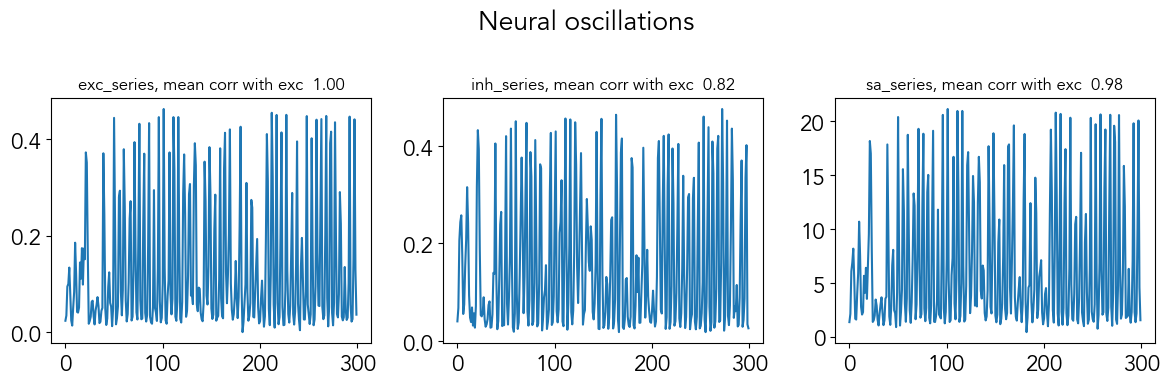

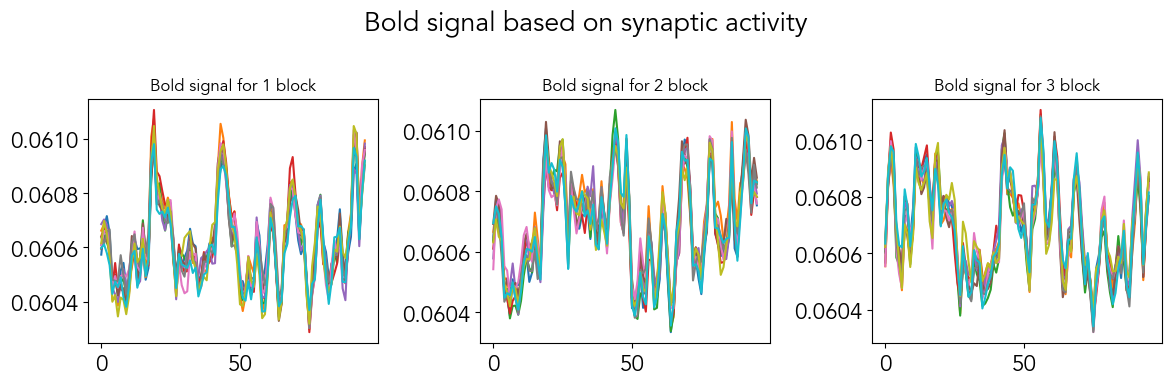

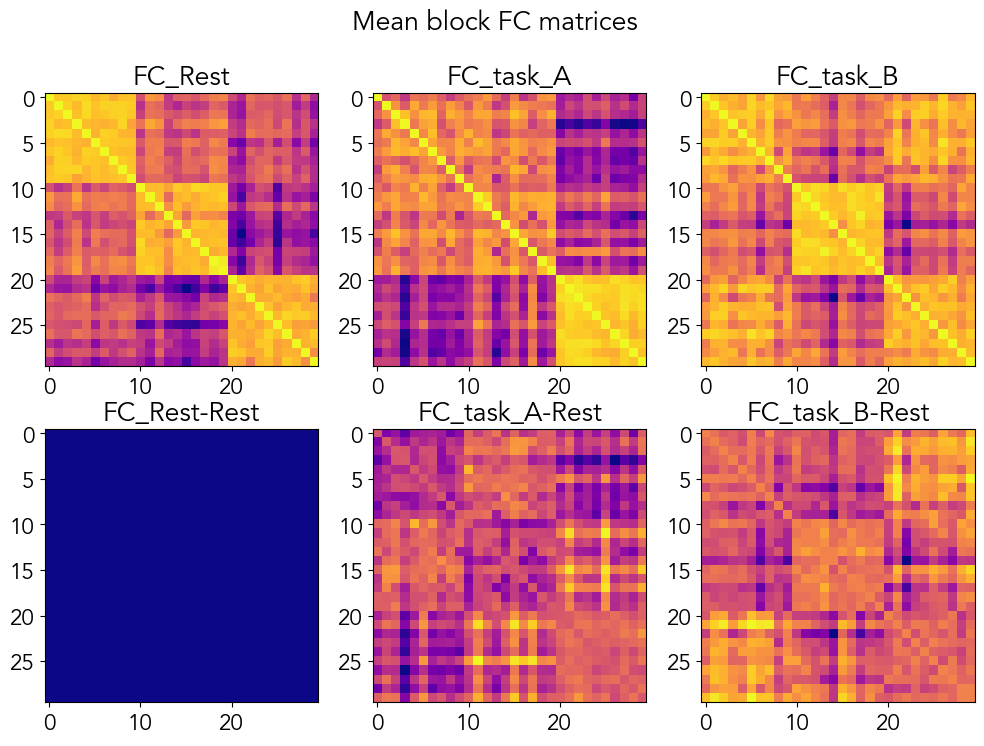

In [29]:
#fix bold response for all regions
wc_block.generate_full_series(bold_chunkwise=True,
                              TR=2,
                              activity=True,
                              a_s_rate=0.02,
                              normalize_max=2,
                              output_activation='syn_act',
                             **bw_params_fix)
#wc_block.time_idxs_dict
neural_series = ['exc_series', 'inh_series', 'sa_series']
r_sa = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                       wc_block.activity['sa_series'][i])[0]
                        for i in range(Wij_rest.shape[0])])

r_inh = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                        wc_block.activity['inh_series'][i])[0]
                         for i in range(Wij_rest.shape[0])])
rs = [1, r_inh, r_sa]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i, series in enumerate(neural_series):
    axs[i].plot(wc_block.activity[series][1, :300].T); 
    axs[i].set_title(f"{series}, mean corr with exc {rs[i]: .2f}", fontsize=12);
fig.suptitle("Neural oscillations"); 
fig.tight_layout() 

ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.BOLD[i*10:i*10+10,12:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
mean_bold_matrices = plot_bold_corr(wc_block, 
                                    TR=2, 
                                    drop_first_rest=8,
                                    drop_start_block=6)

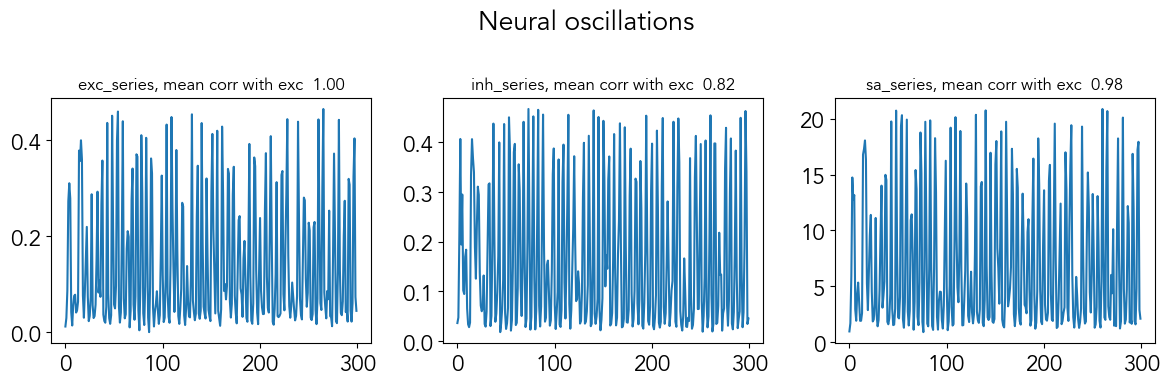

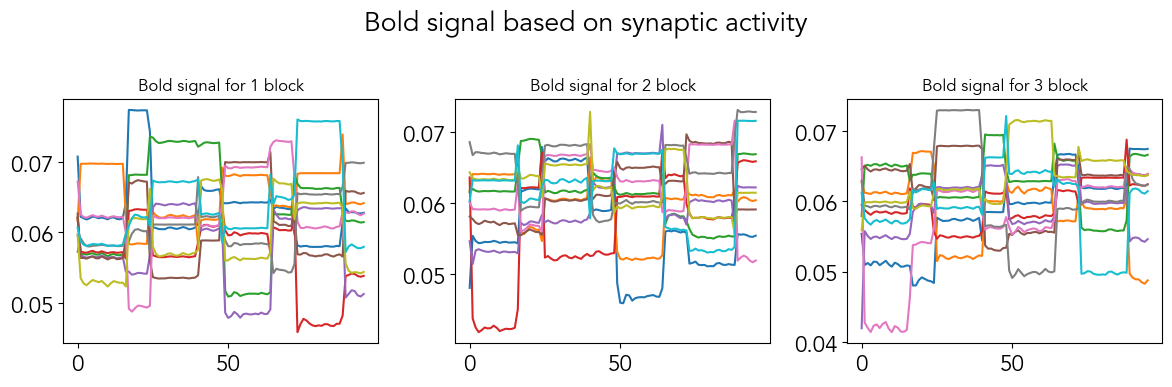

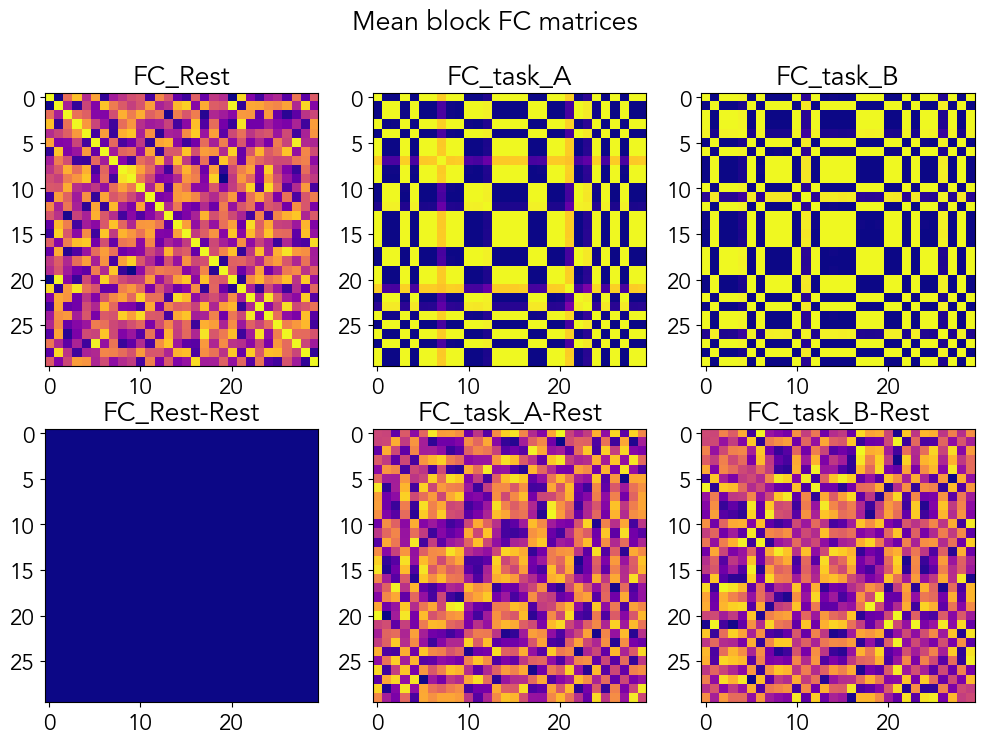

In [31]:
#bad example when every block parameters will be regenerated
wc_block.generate_full_series(bold_chunkwise=True,
                              TR=2,
                              activity=True,
                              a_s_rate=0.02,
                              normalize_max=2,
                              output_activation='syn_act',
                             **bw_params_random)
#wc_block.time_idxs_dict
neural_series = ['exc_series', 'inh_series', 'sa_series']
r_sa = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                       wc_block.activity['sa_series'][i])[0]
                        for i in range(Wij_rest.shape[0])])

r_inh = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                        wc_block.activity['inh_series'][i])[0]
                         for i in range(Wij_rest.shape[0])])
rs = [1, r_inh, r_sa]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i, series in enumerate(neural_series):
    axs[i].plot(wc_block.activity[series][1, :300].T); 
    axs[i].set_title(f"{series}, mean corr with exc {rs[i]: .2f}", fontsize=12);
fig.suptitle("Neural oscillations"); 
fig.tight_layout() 

ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.BOLD[i*10:i*10+10,12:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
mean_bold_matrices = plot_bold_corr(wc_block, 
                                    TR=2, 
                                    drop_first_rest=8,
                                    drop_start_block=6)

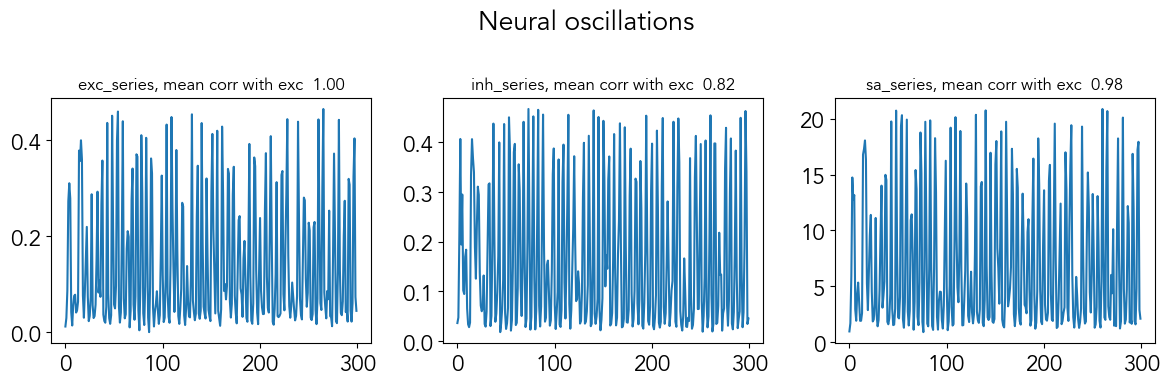

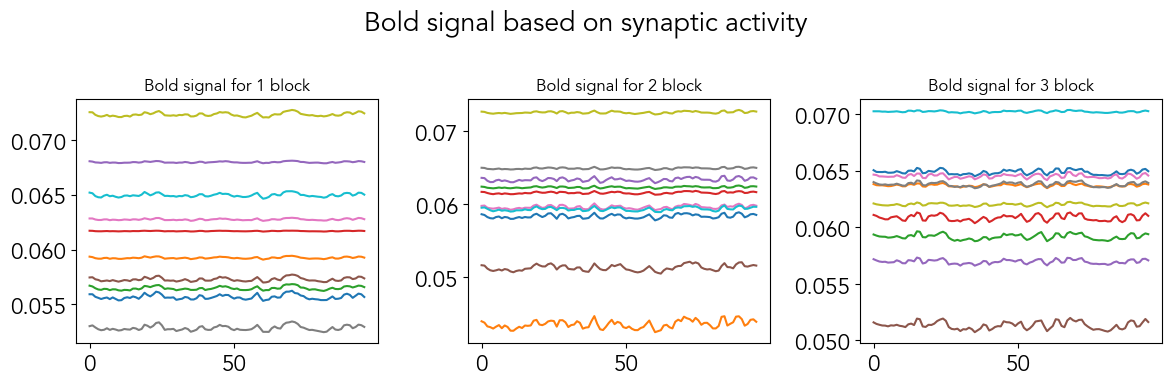

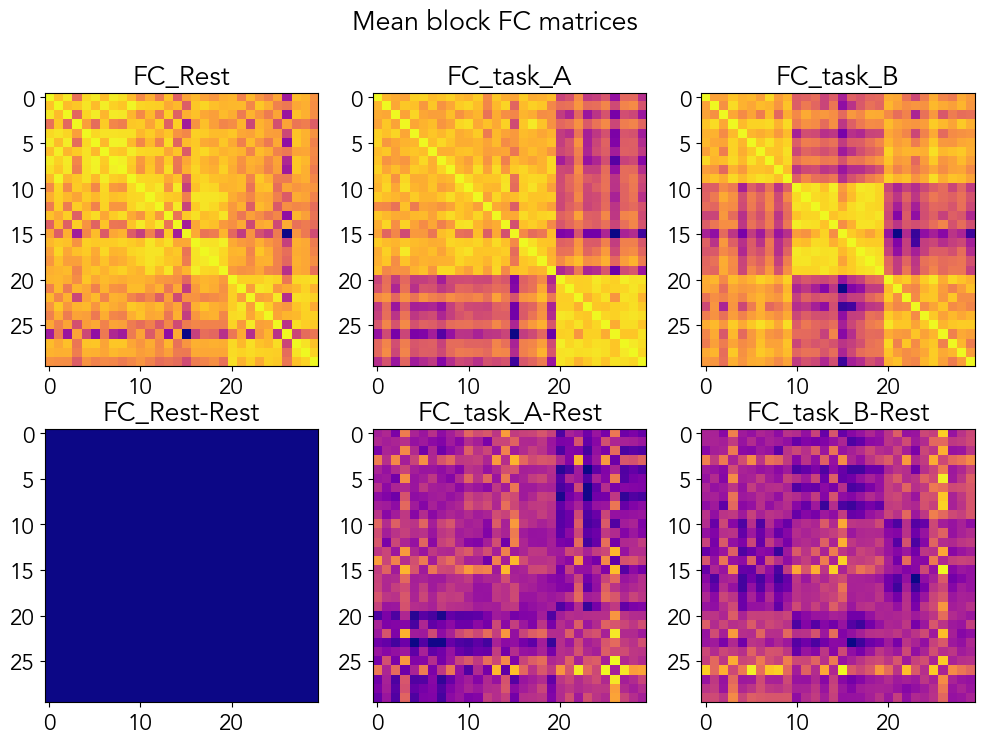

In [32]:
#example when each region has individual bold responce, need to define all params before 
wc_block.generate_full_series(bold_chunkwise=True,
                              TR=2,
                              activity=True,
                              a_s_rate=0.02,
                              normalize_max=2,
                              output_activation='syn_act',
                             **bw_params_indiv)
#wc_block.time_idxs_dict
neural_series = ['exc_series', 'inh_series', 'sa_series']
r_sa = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                       wc_block.activity['sa_series'][i])[0]
                        for i in range(Wij_rest.shape[0])])

r_inh = np.mean([stats.pearsonr(wc_block.activity['exc_series'][i],
                                        wc_block.activity['inh_series'][i])[0]
                         for i in range(Wij_rest.shape[0])])
rs = [1, r_inh, r_sa]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i, series in enumerate(neural_series):
    axs[i].plot(wc_block.activity[series][1, :300].T); 
    axs[i].set_title(f"{series}, mean corr with exc {rs[i]: .2f}", fontsize=12);
fig.suptitle("Neural oscillations"); 
fig.tight_layout() 

ids = [10,20,30]
fig, axs = plt.subplots(1, 3, figsize = (12,4))
for i in range(3):
    axs[i].plot(wc_block.BOLD[i*10:i*10+10,12:].T); 
    axs[i].set_title(f"Bold signal for {i+1} block", fontsize=12);
fig.suptitle("Bold signal based on synaptic activity"); 
fig.tight_layout() 
mean_bold_matrices = plot_bold_corr(wc_block, 
                                    TR=2, 
                                    drop_first_rest=8,
                                    drop_start_block=6)

After generation all timings saved in time index structure, timing in seconds

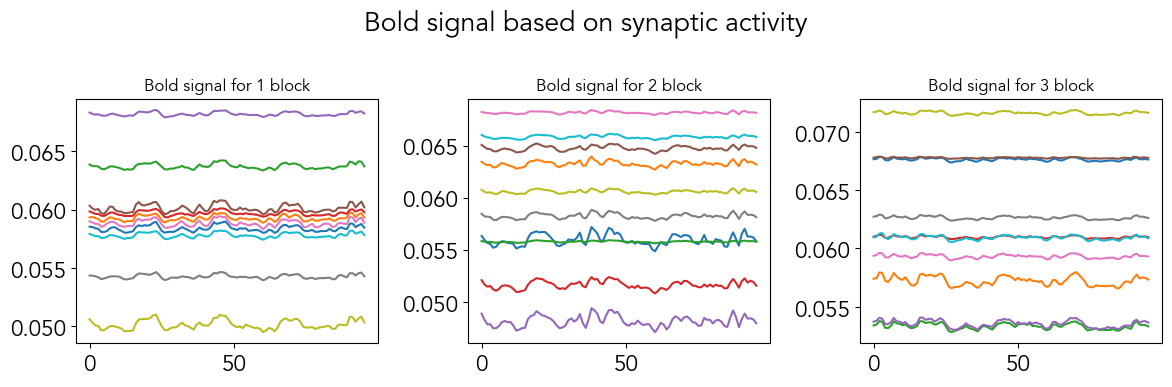

generate BOLD on top of saved synaptic activity with different TR

In [16]:
bold_input = wc_block.activity['sa_series'] 
wc_block.generate_bold(TR=0.75, 
                       drop_first=0,
                       normalize_max=2,
                       conv_type='BW')


TypeError: WCTaskSim.generate_bold() missing 1 required positional argument: 'bold_input'